# COMP64101 - Probabalistic Graphical Networks Lab

## Goals of this weeks lab:


1.   Understand when to use Probabalistic Graphical Networks
2.   Learn about Directed PGM's
3.   Learn about Undirected PGM's

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [1. Introduction to PGM's](#1)
- [2. Directed PGM - Bayes Net](#2)
- [3. Undirected PGM - Markov Net](#3)
- [4. Additional Exercises](#4)




In [ ]:
# Set up the environment for the exercises in this chapter
!python --version

!pip install -qq git+https://github.com/probml/probml-utils.git
!pip install -qq pgmpy

# Notebook wide packages
import numpy as np
import pandas as pd
import pgmpy

Python 3.10.12
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

# 1. An Introduction to PGM's <a class="anchor" id="1"></a>

Probabilistic Graphical Models (PGMs) are a modelling technique where random variables are treated as nodes and statistical dependencies as edges. In otherwords, PGM's offer a visual (graphical) way to interpret complex probabilistic systems. Graphs are an intuitive way for us to realise the relationships between many different variables. They can also be considered as mathematical tools which allow us to reason about uncertainty and make predictions.

<center>
<img src="https://danmackinlay.name/images/Graphical_Models_David_Barber.gif" width=700>

Image Source: https://danmackinlay.name/notebook/graphical_models
</center>


### Why Use PGMs?

The key benefits of PGMs include:

- **Structured Representation**: PGMs give us a clear way to represent complex relationships between variables. This is because we can clearly state how each variable relates to each other variable.
- **Modularity**: The graphical structure allows for modular design, making it easier to update or extend models. If we find a new variable, we can easily connect it into the graph.
- **Inference**: PGMs enable us to calculate probabilities, such as the likelihood of an event given observed evidence. In some cases, the probabilities will be intractable. However, we can still approximate.
- **Learning**: PGM's facilitate learning from data. This allows us to estimate unknown parameters and find patterns in the underlying structures.

### Types of Probabilistic Graphical Models

PGMs can be broadly categorized into two types based on the nature of the dependencies between variables:

1. **Directed Graphical Models (Bayesian Networks)**: In these models, the edges between nodes represent conditional dependencies, and the graph is a Directed Acyclic Graph (DAG). Each node corresponds to a random variable, and the directed edges imply a conditional dependence structure, often represented as $P(X_i | \text{Parents}(X_i))$. Example applications include:
  - Medical diagnosis
  - causal inference
  - sequential decision-making.

<center>
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*mQ_XiRNSEuCTsiqrKzAzXg.gif" width=700>

Image Source: https://miro.medium.com/v2/resize:fit:720/format:webp/1*mQ_XiRNSEuCTsiqrKzAzXg.gif
</center>
   
2. **Undirected Graphical Models (Markov Random Fields)**: Unlike directed models, undirected graphical models use undirected edges to represent dependencies between random variables. These models capture the notion of Markov properties and are often used when the direction of dependencies is not explicitly known or when the relationships are symmetric. Example applications include:
  - Statistical physics
  - Image processing
  - Finance
  - social network analysis.

  We will see an example of image processing in Section 3 of this notebook.

<center>
<img src="https://www.researchgate.net/publication/237134887/figure/fig2/AS:651126194057216@1532251990018/An-acyclic-undirected-graphical-model.png" width=700>

Image Source: https://www.researchgate.net/publication/237134887_Statistical_Inference_in_Graphical_Models
</center>

Both directed and undirected PGMs have their strengths and are used in different applications based on the nature of the problem. We will see examples of both in the upcoming chapters.

## Graph Theory and Probabilistic Models

At the core of PGMs lies the interplay between graph theory and probability theory. The graph structure encodes the relationships between random variables, while probability theory quantifies the uncertainty associated with these variables.

- **Nodes (Vertices)**: Represent random variables in the model.
- **Edges (Links)**: Represent probabilistic dependencies between these variables.
  
  - In directed models, an edge from node \(A\) to node \(B\) implies \(A\) has a direct influence on \(B\).
  - In undirected models, an edge between nodes \(A\) and \(B\) implies a mutual dependence between these variables.


In the next chapter, we will begin to understand directed PGM's.

<center>
<img src="https://mathinsight.org/media/image/image/small_undirected_network_labeled.png" width=500>

Image Source: https://mathinsight.org/network_introduction
</center>



# 2. Directed PGM - Bayes Net <a class="anchor" id="2"></a>

In [ ]:
import probml_utils.pgmpy_utils as pgm
# from causalgraphicalmodels import CausalGraphicalModel
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt

The material in this part is based on:
1. https://github.com/probml/pyprobml/blob/master/notebooks/book2/04/student_pgm.ipynb
2. https://github.com/pgmpy/pgmpy/blob/dev/examples/Learning%20Parameters%20in%20Discrete%20Bayesian%20Networks.ipynb

## Introduction to Directed PGM's

Directed Probabilistic Graphical Models, commonly known as **Bayesian Networks**, are a type of PGM where the relationships between variables are represented using a Directed Acyclic Graph (DAG). In these models, each node corresponds to a random variable, and directed edges between nodes represent conditional dependencies. Bayesian Networks are particularly powerful for modeling causal relationships, where the direction of the edges often reflects the direction of causality.

### Key Properties of Directed PGMs

1. **Directed Acyclic Graph (DAG)**: This means that while edges are form a pathway from one random variable to another, the graph cannot contain cycles. In other words, we cannot start from one node, follow the directed edges, and return to the same node.

2. **Conditional Independence**: If a node \(X\) has no direct edge to another node \(Y\), it implies that \(X\) and \(Y\) are conditionally independent given their parents. This property significantly simplifies the computation of joint probabilities.

3. **Local Probability Distributions**: Each node in a Bayesian Network is associated with a conditional probability distribution that describes the probability of the variable given its parents in the graph. This local distribution encapsulates how the node's value depends on its parent nodes.

### Student network model

To understand how Bayesian Networks work in practice, let's consider a simple  example, known as the **Student Network**. Imagine you're trying to model the factors that influence a student's academic performance. Several variables come into play, such as the student's intelligence, the difficulty of the course, whether they studied for the exam, and the grades they receive. These factors are not independent of each other; for example, a more intelligent student might find it easier to achieve good grades, but this could also depend on how difficult the course is and how much effort they put into studying.

Lets begin by exploring the structure of the data. We begin by defining the structure as a Bayesian network. This is in the form (parent, child):

In [ ]:
# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianNetwork([('Diff', 'Grade'), ('Intel', 'Grade'), ('Grade', 'Letter'), ('Intel', 'SAT')])

In order to visualise this, we define it as a networkx graph:

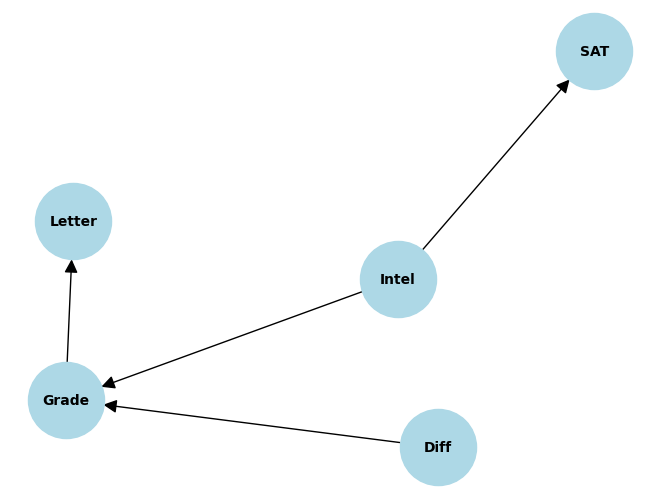

In [ ]:
# Define a graph structure
edges = [('Diff', 'Grade'), ('Intel', 'Grade'), ('Grade', 'Letter'), ('Intel', 'SAT')]
Graph = nx.DiGraph()
Graph.add_edges_from(edges)
pos = nx.spring_layout(Graph)
nx.draw(Graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.show()

We can now build upon the Bayesian network structure by adding in conditional probability distirbutions. In a Bayesian Network, each node (random variable) has an associated CPD that defines the probability of that node given its parents in the graph. If a node has no parents, its CPD is simply its **prior** probability distribution.

For a node $X$ with parents $Y_1, Y_2, \cdots, Y_k$, the CPD specifies $ P(X | Y_1, Y_2, ⋯ Y_k)$. In python, we define these using the state names of the variables. First we begin with Difficulty and Inteligence, since these are based only on their priors.

In [ ]:
# TabularCPD(variable=*variable_name*, variable_card=*Number of possible outcomes*, values=*probabilities*, state_names=*The possible states of the random variable* )
cpd_d_sn = TabularCPD(variable="Diff", variable_card=2, values=[[0.6], [0.4]], state_names={"Diff": ["Easy", "Hard"]})
cpd_i_sn = TabularCPD(variable="Intel", variable_card=2, values=[[0.7], [0.3]], state_names={"Intel": ["Low", "High"]})

The probability of a student having low intelligence is therefore 0.7. Similarly, the probability of a hard exam is 0.4.

Next, we define the child nodes. To do this, we state the parent nodes under evidence as well as the conditional probabilities:

In [ ]:
# CPDs can be defined using the state names of the variables. If the state names are not provided pgmpy will automatically assign names as: 0, 1, 2, ....
# TabularCPD(variable=*variable_name*, variable_card=*Number of possible outcomes*, values=*probabilities* evidence=*parent nodes*, evidence_card=*number of outcomes for parents*, state_names=*The possible states of the random variable*)

cpd_l_sn = TabularCPD(
    variable="Letter",
    variable_card=2,
    values=[[0.1, 0.4, 0.99],  # P(Letter = Bad | Grade)
            [0.9, 0.6, 0.01]], # P(Letter = Good| Grade)
    evidence=["Grade"],
    evidence_card=[3],
    state_names={"Letter": ["Bad", "Good"], "Grade": ["A", "B", "C"]},
)

cpd_s_sn = TabularCPD(
    variable="SAT",
    variable_card=2,
    values=[[0.95, 0.2], # P(SAT = Bad | Intel)
            [0.05, 0.8]],# P(SAT = Good| Intel)
    evidence=["Intel"],
    evidence_card=[2],
    state_names={"SAT": ["Bad", "Good"], "Intel": ["Low", "High"]},
)
cpd_g_sn = TabularCPD(
    variable="Grade",
    variable_card=3,
    values=[[0.3, 0.05, 0.9, 0.5],  # P(Grade = A | Intel, Diff)
            [0.4, 0.25, 0.08, 0.3], # P(Grade = B | Intel, Diff)
            [0.3, 0.7, 0.02, 0.2]], # P(Grade = C | Intel, Diff)
    evidence=["Intel", "Diff"],
    evidence_card=[2, 2],
    state_names={"Grade": ["A", "B", "C"], "Intel": ["Low", "High"], "Diff": ["Easy", "Hard"]},
)



Above, we defined 2 dependencies. First, we defined the CPD's of the letter variable. This has variable_card=2 i.e. 2 outcomes which are defined as ["Bad", "Good"]. Furthermore, it has one parent: Grade (which can be seen in the evidence field) which can take 3 values (evidence_card=[3]) with labels "Grade": ["A", "B", "C"].

The values field contains two separate lists. Each of these lists corresponds to one of the outcomes i.e. Bad or Good. the probabilities [0.1, 0.4, 0.99] correspond to [P(Bad letter | Grade A), P(Bad letter | Grade B), P(Bad letter | Grade C)], while [0.9, 0.6, 0.01] corresponds to [P(Good letter | Grade A), ...].

Next, we associate the CPD's with the network as follows:

In [ ]:
# Associating the CPDs with the network
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)

In [ ]:
# Printing a CPD with it's state names defined.
print(model.get_cpds("Grade"))

+----------+------------+------------+-------------+-------------+
| Intel    | Intel(Low) | Intel(Low) | Intel(High) | Intel(High) |
+----------+------------+------------+-------------+-------------+
| Diff     | Diff(Easy) | Diff(Hard) | Diff(Easy)  | Diff(Hard)  |
+----------+------------+------------+-------------+-------------+
| Grade(A) | 0.3        | 0.05       | 0.9         | 0.5         |
+----------+------------+------------+-------------+-------------+
| Grade(B) | 0.4        | 0.25       | 0.08        | 0.3         |
+----------+------------+------------+-------------+-------------+
| Grade(C) | 0.3        | 0.7        | 0.02        | 0.2         |
+----------+------------+------------+-------------+-------------+


In [ ]:
for cpd in model.get_cpds():
    print(cpd)

+------------+-----+
| Diff(Easy) | 0.6 |
+------------+-----+
| Diff(Hard) | 0.4 |
+------------+-----+
+-------------+-----+
| Intel(Low)  | 0.7 |
+-------------+-----+
| Intel(High) | 0.3 |
+-------------+-----+
+----------+------------+------------+-------------+-------------+
| Intel    | Intel(Low) | Intel(Low) | Intel(High) | Intel(High) |
+----------+------------+------------+-------------+-------------+
| Diff     | Diff(Easy) | Diff(Hard) | Diff(Easy)  | Diff(Hard)  |
+----------+------------+------------+-------------+-------------+
| Grade(A) | 0.3        | 0.05       | 0.9         | 0.5         |
+----------+------------+------------+-------------+-------------+
| Grade(B) | 0.4        | 0.25       | 0.08        | 0.3         |
+----------+------------+------------+-------------+-------------+
| Grade(C) | 0.3        | 0.7        | 0.02        | 0.2         |
+----------+------------+------------+-------------+-------------+
+--------------+----------+----------+----------

To view this as a graph structure, we can also use the pgm.visualize_model function:

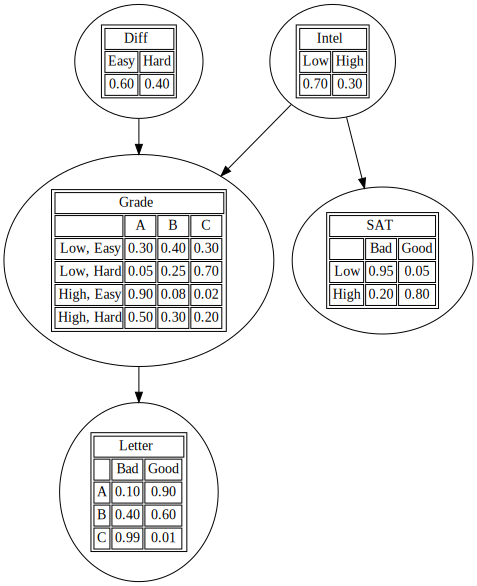

In [ ]:
dot = pgm.visualize_model(model)
display(dot)

Now that we have looked at visualising graphical models. We get to the reason why they are useful in the first place. Specifically, we begin to explore inference techniques in Bayes Net's.

## Inference

Inference in Bayesian Networks involves calculating the probability of certain outcomes given some evidence. This process allows us to answer questions like "What is the probability that a student is intelligent given that they received an 'A' grade?" or "How likely is it that the course was difficult if we know the student got a 'C' grade?" Inference is one of the most powerful features of Bayesian Networks, as it enables reasoning under uncertainty by updating beliefs based on new evidence.


### Types of Inference

There are different types of inference that can be performed in a Bayesian Network:

1. **Conditional Inference:** This involves calculating the probability of a variable given some observed evidence. For example, what is the probability that the student has a High intelligence (Intel=High) given that they got a B grade (Grade=B)?

2. **Marginal Inference:** This involves calculating the probability of a particular variable without any evidence. For instance, in our Student Network, we might want to know the prior probability that a student gets a Letter of recommendation (P(Letter)), regardless of any other information.

3. **MAP (Maximum A Posteriori)** Inference: This type of inference finds the most probable state of a set of variables given some evidence. In the Student Network, we might want to determine the most likely intelligence level (Intel) of a student given their Grade and SAT scores.


pgmpy has a built in inference package which allows us to easily do inference in the graphs. We begin by importing this!

In [ ]:
from pgmpy.inference import VariableElimination

**VariableElimination** is a class, which is  provided by pgmpy, that implements the Variable Elimination algorithm for performing exact inference in Bayesian Networks. This is instantiated for our Bayesian model:

In [ ]:
infer = VariableElimination(model)

### Calculating Conditional Probabilities

In Bayesian Networks, calculating posterior probabilities is a key aspect of inference that allows us to update our beliefs about the state of a variable based on observed evidence. A posterior probability, such as P(Difficulty = Hard | Grade = C),  represents the probability that the course difficulty is Hard given that a student received a C grade. Posteriors can be calcualted as follows:

In [ ]:
evidence = {"Grade": "C"}
postD = infer.query(["Diff"], evidence=evidence).values
postI = infer.query(["Intel"], evidence=evidence).values

print("\n")
print("Pr(Difficulty=Hard|Grade=C) = {:0.2f}".format(postD[1]))
print("Pr(Intelligence=High|Grade=C) = {:0.2f}".format(postI[1]))



Pr(Difficulty=Hard|Grade=C) = 0.63
Pr(Intelligence=High|Grade=C) = 0.08


Try to calculate: P(Difficulty=Hard|Grade=C,SAT=Good) and P(Intelligence=High|Grade=C,SAT=Good) in the box below:

In [ ]:
# Modify this box to print the probabilities
evidence =
postD =
postI =

print("\n")
print("Pr(Difficulty=Hard|Grade=C,SAT=Good) = {:0.2f}".format(postD[1]))
print("Pr(Intelligence=High|Grade=C,SAT=Good) = {:0.2f}".format(postI[1]))

### Calculating Marginal Probabilities

#### Marginal without evidence

Marginal probability without evidence refers to the probability of a single variable in a Bayesian Network without considering any other information or observed evidence. It represents our belief about the possible states of a variable based solely on the prior information encoded in the network. For instance, in the Student example, we might be interested in calculating the probability distribution of the Grade variable across all possible grades (A, B, or C), regardless of other factors like Intelligence or Difficulty. This type of probability is useful for understanding the general tendencies in the model without any additional context. By computing marginal probabilities, we can answer questions such as "What is the overall probability that a student will get a B grade?" or "How likely is it that a student will receive a letter of recommendation (Letter=Yes)?"


To calculate the marginal probability distribution of the grade variable, we can use the following the function:

In [ ]:
# Calculate the marginal probability distribution of the 'Grade' variable
marginal_grade = infer.query(variables=['Grade'])
print(marginal_grade)

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.3620 |
+----------+--------------+
| Grade(B) |       0.2884 |
+----------+--------------+
| Grade(C) |       0.3496 |
+----------+--------------+


Try to do this below for the SAT scores:

In [ ]:
# Calculate the marginal probability distribution of the 'SAT' variable
marginal_grade =
print(marginal_grade)

In [ ]:
# Model sols (Remove before publishing):
marginal_grade = infer.query(variables=['Grade'])
print(marginal_grade)

+----------+--------------+
| Grade    |   phi(Grade) |
+==========+==============+
| Grade(A) |       0.3620 |
+----------+--------------+
| Grade(B) |       0.2884 |
+----------+--------------+
| Grade(C) |       0.3496 |
+----------+--------------+


This can be verified using the pgm.get_marginals package. Check that your answer matches the output below:

In [ ]:
evidence = {}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

{'Diff': array([0.6, 0.4]), 'Grade': array([0.362 , 0.2884, 0.3496]), 'Intel': array([0.7, 0.3]), 'Letter': array([0.497664, 0.502336]), 'SAT': array([0.725, 0.275])}


We can also visualise the marignals as seen below:

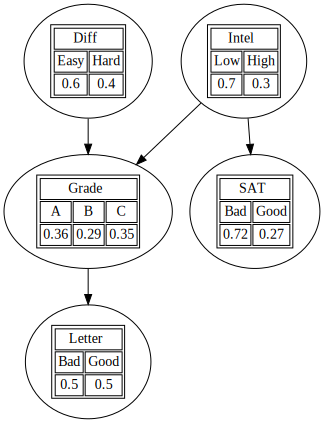

In [ ]:
dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)

#### Marginal with evidence

Marginal probability with evidence involves calculating the probability distribution of a variable while taking into account observed evidence for other variables. This type of probability reflects our updated belief about a variable given that certain pieces of information are known. For instance, in the Student example, if we want to compute the marginal probability of the Difficulty variable given that a student received a C grade, we would calculate P(Difficulty∣Grade=C). This process involves updating the network with the observed evidence (Grade = C) and then computing the marginal probability for Difficulty. By considering the evidence, we refine our understanding of the probability distribution for the variable of interest, providing insights into how the observed data influences our beliefs about the other variables.

To calculate the Marginal porbability of Difficulty given Grade = A:

In [ ]:
marginal_difficulty = infer.query(variables=['Diff'], evidence={'Grade': 'A'})
print(marginal_difficulty)

+------------+-------------+
| Diff       |   phi(Diff) |
+============+=============+
| Diff(Easy) |      0.7956 |
+------------+-------------+
| Diff(Hard) |      0.2044 |
+------------+-------------+


Now try to calculate the marginal of SAT given Grade = B.

In [ ]:
# Answer here
marginal_difficulty =
print(marginal_difficulty)

Similarly to before, this can be verified and visualised using the pgm package. Check that your answer matches the output below:

{'Diff': array([0.37070938, 0.62929062]), 'Grade': array([0., 0., 1.]), 'Intel': array([0.92105263, 0.07894737]), 'Letter': array([0.99, 0.01]), 'SAT': array([0.89078947, 0.10921053])}


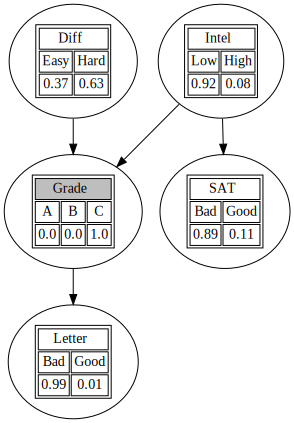

In [ ]:
# Calculate the margionals with evidence
evidence = {"Grade": "C"}
marginals = pgm.get_marginals(model, evidence)
print(marginals)

# Visualise the margionals with evidence
dot = pgm.visualize_marginals(model, evidence, marginals)
display(dot)

Try to calculate the marginal for Difficulty with evidence Grade = C and SAT = Good. Verify this using the pgm package.

In [ ]:
# Calculate the margional for Difficulty with both Grade and SAT as evidence

# Verify your answer using the pgm package

# Visualise the marginals with the pgm package


### MAP (Maximum A Posteriori) in Bayes Net's

MAP inference is a method used in Bayesian Networks to find the most probable state of a set of variables given some observed evidence. Unlike marginal probability, which gives the probability distribution of a variable, MAP inference focuses on identifying the specific values of variables that maximize the posterior probability. Essentially, it helps us determine the most likely configuration of variables given the evidence we have. This is particularly useful for making decisions or predictions based on the observed data.

Below, there is an example which finds the most likely difficulty given the grade is A:

In [ ]:
# Perform MAP inference
map_diff_given_grade_a = infer.map_query(variables=['Diff'], evidence={'Grade': 'A'})
print("Most likely difficulty given Grade = A:", map_diff_given_grade_a)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Most likely difficulty given Grade = A: {'Diff': 'Easy'}


Try to have a go at finding the most probable difficulty and inteligence given grade=B and SAT=High

In [ ]:
# Perform MAP inference
map_vars_given_evidence =
print("Most likely Intelligence given Grade = B", map_vars_given_evidence)


In [ ]:
# Model sols (Remove before publishing):
# Perform MAP inference
map_vars_given_evidence = infer.map_query(variables=['Intel'], evidence={'Grade': 'B'})
print("Most likely Intelligence given Grade = B", map_vars_given_evidence)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Most likely Intelligence given Grade = B {'Intel': 'Low'}


## Learning Parameters in Bayesian Networks


In Bayesian Networks, parameter learning refers to the process of estimating the Conditional Probability Distributions (CPDs) based on data. These parameters define how the probability of each variable depends on its parents in the network. Learning the parameters is crucial for building accurate models that reflect real-world data. There are two main approaches to parameter learning:

1. **Maximum Likelihood Estimation (MLE)**: This approach estimates the parameters by maximizing the likelihood of the observed data given the model. MLE is typically used when you have a complete dataset and want to find the parameters that best fit this data.

2. **Bayesian Estimation**: This approach incorporates prior distributions on the parameters and updates these priors based on the observed data to obtain posterior distributions. Bayesian Estimation is useful when you have prior beliefs about the parameters and want to refine these beliefs with data.

### **Maximum Likelihood Paramter Estimation**

Maximum Likelihood Estimation estimates the parameters of a Bayesian Network by finding the parameter values that maximize the likelihood of the observed data. In other words, MLE chooses the parameters that make the observed data most probable under the model.

We begin by generating a dataset for the student model:

In [ ]:
from pgmpy.sampling import BayesianModelSampling
samples = BayesianModelSampling(model).forward_sample(size=int(1e5))


  0%|          | 0/5 [00:00<?, ?it/s]

We can visualise some of the data using the head() function.

In [ ]:
samples.head()

,Diff,Grade,Intel,Letter,SAT
0,Easy,C,Low,Bad,Bad
1,Easy,C,Low,Bad,Bad
2,Easy,A,High,Bad,Good
3,Hard,A,High,Good,Good
4,Easy,A,High,Good,Good


Similarly to before, we generate a model structure which contains the base graph. The goal is to learn the values of nodes and edges of this graph.

In [ ]:
model_struct = BayesianNetwork(ebunch=model.edges())
model_struct.nodes()

NodeView(('Diff', 'Grade', 'Letter', 'Intel', 'SAT'))

#### Learning the model parameters

We can now begin learning the parameters of the model:

In [ ]:
# Fitting the model using Maximum Likelihood Estimator

from pgmpy.estimators import MaximumLikelihoodEstimator

mle = MaximumLikelihoodEstimator(model=model_struct, data=samples)

# Estimating the CPD for a single node.
print(mle.estimate_cpd(node="Diff"))
print(mle.estimate_cpd(node="Grade"))

# Estimating CPDs for all the nodes in the model
mle.get_parameters()

+------------+---------+
| Diff(Easy) | 0.60206 |
+------------+---------+
| Diff(Hard) | 0.39794 |
+------------+---------+
+----------+----------------------+-----+---------------------+---------------------+
| Diff     | Diff(Easy)           | ... | Diff(Hard)          | Diff(Hard)          |
+----------+----------------------+-----+---------------------+---------------------+
| Intel    | Intel(High)          | ... | Intel(High)         | Intel(Low)          |
+----------+----------------------+-----+---------------------+---------------------+
| Grade(A) | 0.9008347245409015   | ... | 0.5006672226855713  | 0.04920155373327579 |
+----------+----------------------+-----+---------------------+---------------------+
| Grade(B) | 0.07762938230383973  | ... | 0.29599666388657214 | 0.24881312041432888 |
+----------+----------------------+-----+---------------------+---------------------+
| Grade(C) | 0.021535893155258765 | ... | 0.20333611342785654 | 0.7019853258523954  |
+----------+---

[<TabularCPD representing P(Diff:2) at 0x79786445bc70>,
 <TabularCPD representing P(Grade:3 | Diff:2, Intel:2) at 0x79786428f7c0>,
 <TabularCPD representing P(Letter:2 | Grade:3) at 0x79786428fe20>,
 <TabularCPD representing P(Intel:2) at 0x79786428f820>,
 <TabularCPD representing P(SAT:2 | Intel:2) at 0x79785c5cfeb0>]

In [ ]:
# Verifying that the learned parameters are almost equal.

np.allclose(
    model.get_cpds("Diff").values, mle.estimate_cpd("Diff").values, atol=0.01
)

True


### **Bayesian Estimation**

Bayesian Estimation estimates the parameters by updating prior distributions with observed data to obtain posterior distributions. This method provides a probabilistic view of the parameters, which includes uncertainty about their values. pgmpy also has a built in class to handle this:

In [ ]:
# Fitting the using Bayesian Estimator

from pgmpy.estimators import BayesianEstimator

bayesian_model = BayesianEstimator(model=model_struct, data=samples)

# Uniform pseudo count for each state. Can also accept an array of the size of CPD.
print(bayesian_model.estimate_cpd(node="Diff", prior_type="dirichlet", pseudo_counts=100))


+------------+----------+
| Diff(Easy) | 0.601856 |
+------------+----------+
| Diff(Hard) | 0.398144 |
+------------+----------+


# 3. Undirected PGM - Markov Net <a class="anchor" id="3"></a>
The material in this chapter is based on:
1. https://www.youtube.com/watch?v=rN7g4gzO2sk&list=PLcKyTzEkOa-gxU14ehctpaQdhE2GOFpeb
2. https://github.com/probml/pyprobml/blob/master/notebooks/book2/04/gibbs_demo_ising.ipynb


Undirected Probabilistic Graphical Models (PGMs), also known as Markov Networks or Markov Random Fields, are a class of models used to represent the joint distribution of a set of random variables without specifying direct causal relationships between them. Unlike directed PGMs, which use directed edges to denote causal dependencies, undirected PGMs use undirected edges to capture the dependencies and conditional independencies among the variables.

## Key Properties of Undirected PGM's


- **Undirected Graphs**: In undirected PGMs, edges do not have a direction. They simply indicate that the connected variables are dependent on each other.
- **Clique**: A subset of variables in a Markov Network where every pair of variables is directly connected by an edge. The joint probability distribution can be expressed in terms of these cliques.
- **Potential Functions**: Instead of conditional probability tables (CPTs), undirected PGMs use potential functions or factors to define the joint distribution over cliques. These functions capture how variables interact with each other.


Consider a simple undirected graph with three variables: `A`, `B`, and `C`. The edges are undirected and connect each pair of variables, forming a complete graph. In this graph, `A` is connected to `B`, `B` is connected to `C`, and `A` is connected to `C`. This represents a fully connected system where each variable influences every other variable, but the exact nature of these influences is captured by potential functions.


To visualize an undirected PGM, you can use libraries such as `networkx`. Here’s a brief example of how you might represent and visualize a simple undirected PGM using `networkx`:


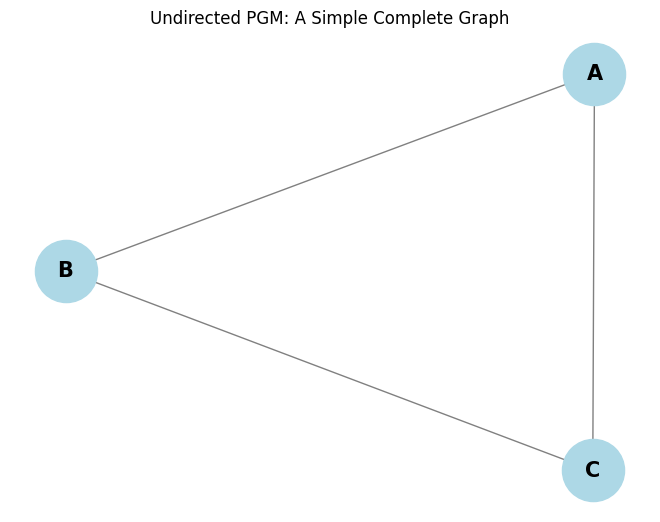

In [ ]:
# Create an undirected graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(['A', 'B', 'C'])

# Add edges
G.add_edges_from([('A', 'B'), ('B', 'C'), ('A', 'C')])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=15, font_weight='bold')
plt.title('Undirected PGM: A Simple Complete Graph')
plt.show()

In undirected PGMs, the joint probability distribution over the variables is expressed as a product of potential functions over cliques. This representation allows for a flexible way of modeling dependencies without assuming a specific direction of influence. Inference in undirected PGMs often involves summing over variables to compute marginal distributions or using algorithms like Belief Propagation to perform approximate inference.

To describe these concepts further, we will consider an Ising model.

## Ising model

The Ising Model is a type of undirected probabilistic graphical model used to study the behavior of magnetic materials. It consists of a grid of binary variables, each representing the spin of an electron (that can be either +1 (up) or -1 (down)). These spins interact with their neighbors, and the goal is to understand the collective behavior of the spins given certain interactions and external influences.


### Key Concepts

- **Binary Variables**: Each variable (or spin) in the Ising model can be in one of two states: +1 or -1.
- **Neighbors**: Spins are arranged in a lattice, and each spin interacts with its neighboring spins. The interactions between neighboring spins are described by coupling constants.
- **Potential Function**: The energy of a configuration in the Ising model is defined by a potential function that captures the interaction between neighboring spins.


Let’s consider a simple 2D Ising model with a 4x4 grid. Each spin interacts with its nearest neighbors (left, right, top, bottom). Red represents a spin of +1 while blue represents a spin of -1.

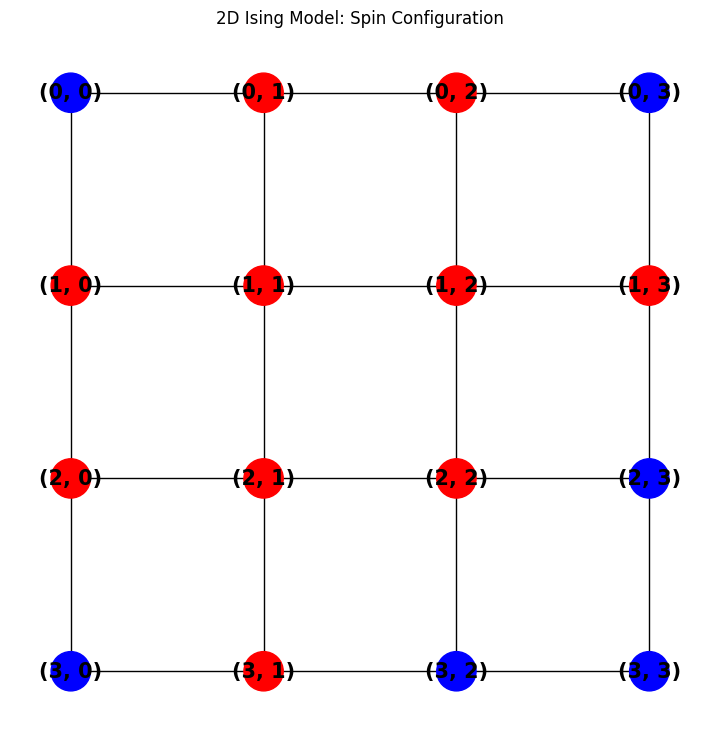

Energy of the configuration: -4


In [ ]:
# Define the size of the grid
size = 4

# Create a grid graph to represent the Ising model
G = nx.grid_2d_graph(size, size, periodic=False)

# Define a random configuration of spins (+1 or -1)
np.random.seed(0)
spins = np.random.choice([-1, 1], size=(size, size))

# Plot the grid and the spins
pos = {(x, y): (y, -x) for x, y in G.nodes()}
colors = ['red' if spins[x, y] == 1 else 'blue' for x, y in G.nodes()]

plt.figure(figsize=(7, 7))
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=800, font_size=15, font_weight='bold')
plt.title('2D Ising Model: Spin Configuration')
plt.show()

# Calculate the energy of the configuration
def compute_energy(spins, J=1):
    energy = 0
    for (i, j) in G.edges():
        energy -= J * spins[i] * spins[j]
    return energy

# Compute and print the energy of the configuration
energy = compute_energy(spins)
print("Energy of the configuration:", energy)

### Scaling up
We can now scale this up to a general case. In the Ising model, the probability of a given configuration of spins \( X \) is defined by the Boltzmann distribution. The probability is proportional to the exponential of the negative energy of the configuration, normalized by the partition function.

Consider the 2d lattice $X \in \mathbb{R}^{N \times M}$, where $x_{nm}$ is a random variable, taking values from $\{-1, +1\}$. The formula is:

$$ P(X; J) = \frac{1}{Z(J)} \exp(-E(X; J)) $$


Where:
-  $P(X; J)$ is the probability of the spin configuration \( X \) given the coupling constant \( J \). In the study of the behavior of magnetic materials, the temperature affects the coupling stength \( J \). The lower temperature leads to more tightly coupled (larger J), and higher temperature means less tightly coupled (smaller J).
-  $E(X; J)$ is the energy of the configuration \( X \), which is a function of the spins and their interactions.
-  $Z(J)$ is the partition function, a normalization constant that ensures the probabilities sum to 1: $ Z(J) = \sum_{X} \exp(-E(X; J)) $

### Gibbs sampling for Inference:

Gibbs Sampling is a Markov Chain Monte Carlo (MCMC) method used to approximate the distribution of a set of variables. In the context of the Ising model, Gibbs Sampling helps in approximating the posterior distribution of spins given the interactions and external fields.


#### Steps for Gibbs Sampling

1. **Initialization**: Start with an initial configuration of spins.
2. **Sampling**: Update each spin sequentially based on the conditional distribution of that spin given the current values of its neighbors.
3. **Iteration**: Repeat the sampling process for a large number of iterations to approximate the distribution.


The gibbs formula is:

$$p(x_{nm}=+1 \mid X_{\setminus nm}) = \frac{p(x_{nm}=+1, X_{\setminus nm})}{p(x_{nm}=+1, X_{\setminus nm}) + p(x_{nm}=-1, X_{\setminus nm})} = \frac{1}{1 + \exp[-e(x_{nm}=-1;J)+e(x_{nm}=+1; J)]} = \frac{1}{1 + \exp[2e(x_{nm}=+1;J)]}$$

where we use notation $X_{\setminus nm}$ to represent all variables in $X$ but $x_{nm}$. The notation $e(x_{nm}; J) = \sum_{x^{\prime} \text{that are connected to node } x_{nm}} -J x^{\prime}x_{nm}$.
We also use the fact: $e(x_{nm}=+1; J) = - e(x_{nm}=-1; J).$

In [ ]:
# 3 options of initial configuration of spins.

def positive_spin_field(N, M):
    return np.ones((N, M))

def negative_spin_field(N, M):
    return -1 * np.ones((N, M))

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

# You may write your own initial configuration...

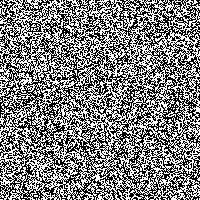

In [ ]:
from PIL import Image

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) / 2 * 255))

display_spin_field(random_spin_field(200, 200))

In [ ]:
def ising_step(field, J=0.4):
    """Perform Ising Update over entire lattice"""
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
             for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2) :
                    _ising_update(field, n, m, J)
    return field

def _energy(field, n, m, J):
    """
    Calculate Energy of a single site (n, m) assuming x_nm = 1.
    """
    total = 0
    N, M = field.shape
    # be careful of the boundary
    for i in range(max(0, n - 1), min(N, n + 2)):
        for j in range(max(0, m - 1), min(M, m + 2)):
            if i == n and j == m:
                continue
            total += field[i, j]
    total *= -J
    return total

def _ising_update(field, n, m, J):
    """
    Perform Ising Update (Gibbs sampling) for a single site (n, m)
    """
    if np.random.rand() < 1 / (1 + np.exp(2 * _energy(field, n, m, J))):
        field[n, m] = 1
    else:
        field[n, m] = -1

### Animate Sequence with ipywidgets

In [ ]:
from ipywidgets import interact

# animate the evolution of the Ising model
def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])

    return interact(_show)

In [ ]:
np.random.seed(44)                     # Try different random seeds, e.g. 44, 46
images = [positive_spin_field(30, 30)] # Try different initial configs, such as negative_spin_field, random_spin_field etc
J0, T0, Tf = 10., 1., 100.             # J0: base coupling strength; TO: initial temperature; Tf: the highest temperature
temp = [T0]
num_iter = 1000                        # number of iterations to run

# This loop will take some time, please be patient.
for i in range(num_iter):

    if i < num_iter / 2:
        # during the first half of iters, as the temperature increase (smaller coupling strength),
        # the distribution becomes more entropic, losing magnestism.
        T = T0 + (Tf - T0) * (i + 1) / (num_iter / 2)

    elif i >= num_iter / 2:
        # after the first half of iters, the temperature start decreasing (larger coupling strength),
        # the distribution becomes less entropic, recovering magnestism.
        T = Tf - (Tf - T0) * (i + 1 - (num_iter / 2)) / (num_iter / 2)

    J = J0 / T
    images.append(ising_step(images[-1].copy(), J=J))
    temp.append(T)

display_ising_sequence(images)

interactive(children=(IntSlider(value=500, description='frame', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 1000))>

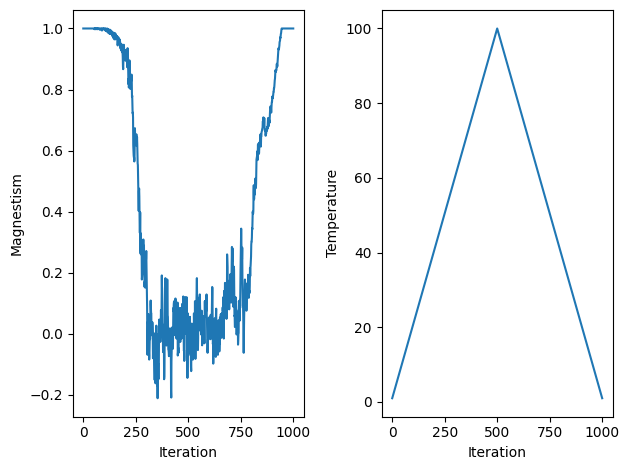

In [ ]:
import matplotlib.pyplot as plt

# Plot the evolution of the magnetization
plt.subplot(1, 2, 1)
plt.plot(range(len(images)), [images[i].mean() for i in range(len(images))])
plt.xlabel('Iteration')
plt.ylabel('Magnestism')

plt.subplot(1, 2, 2)
plt.plot(range(len(images)), temp)
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()

In the Ising model, the temperature T plays an important role. At low temperatures, thermal fluctuations are minimal, and the system tends to minimize its energy by aligning spins (strong coupling, large J), resulting in a net magnetization (ferromagnetic state). However, as the temperature increases, thermal energy can overcome the interaction energy between spins (weak coupling, small J), leading to more random spin orientations and a reduction in net magnetization.

One may notice that there is a critical temperature in the above evolution ($T_c \in $60~80), known as the Curie temperature in magnetic materials, is a pivotal point in the Ising model. Below $T_c$, the material exhibits spontaneous magnetization, where even without an external magnetic field, the spins tend to align, creating a magnetized state. Above $T_c$, the thermal agitation becomes dominant, and the system transitions to a paramagnetic state, where the spins are randomly oriented, and the net magnetization vanishes.

When the temperature is decreased from a high value (above $T_c$) back down, the system might not immediately return to its original magnetized state. This lag is known as hysteresis. The material may retain some magnetization due to the history of its thermal evolution, demonstrating the irreversible nature of some processes in magnetic materials. Under certain conditions, the direction of magnetization can reverse during the cooling process (e.g. random seed=46).

##Image denoising with Ising model

In this section, we provide an toy application for image denoising with Ising model prior. Given an image, we treat image pixels as random variables, denoted as $X \in \mathbb{R}^{N \times M}$. To capture the correlation between pixels, we put Ising model prior on $X$. The original image $X$ can sometime be corrputed in many senarios, such as during data transmission, resulting to a noisy image denoted as $Y$. Our goal here is to recover "clean" image $X$ given noisy observation $Y$, with the help of Ising model. This example is inspired by Kevin's book Section 4.3.9.

In [ ]:
import pandas as pd

img = pd.read_csv('https://raw.githubusercontent.com/probml/probml-data/main/data/letterA.csv').to_numpy()

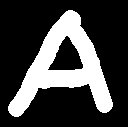

In [ ]:
mean = np.mean(img)
img_clean = np.where(img > mean, 1, -1)

display_spin_field(img_clean)

We can artificially inject random noise to original clean image. The noise level is the standard deviation of the Gaussian noise.

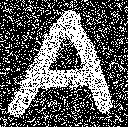

In [ ]:
noise_level = 0.01
img_noisy = img_clean.astype('float') + np.random.randn(*img_clean.shape) * noise_level # try different noise level

display_spin_field(img_noisy)

As mentioned above, the prior $p(X)$ is modelled as a Ising model. We can freely determine the observation likelihood $p(Y \mid X)$. The simplest choice is Gaussian likelihood: $p(Y \mid X) = \mathcal{N}(Y \mid X, \sigma^2I)$. Our denoising target can be achieved by optimizing log posterior $\log p(X \mid Y)$ w.r.t. $X$.

$$X_{*} = \arg \max_{X} \log p(X \mid Y) \propto \arg \max_{X} \{-\log Z(J) + J \cdot \sum_{i \sim j} x_{i} x_{j} + \sum_{n} \sum_{m} \log p(y_{nm} \mid x_{nm})\}$$

where the $i \sim j$ notation means edges in the Ising model.

In [ ]:
def gaussian_log_likelihood(obs, mean, std=1.):
    return -0.5 * np.log(2 * np.pi) - np.log(std) - (obs - mean) ** 2 / (2 * std ** 2)

def laplace_log_likelihood(obs, mean, b=1.):
    return -np.log(2 * b) - np.abs(obs - mean) / b

# You may try some other log likelihood functions ...

In [ ]:
def denoising_step(noisy_img, field, log_obs_likelihood, J=0.4, num_iter=1):
    """
    A heuristic approach for maximizing :math: '\log p(X|Y)'.
    """
    assert noisy_img.shape == field.shape
    N, M = noisy_img.shape
    for iter in range(num_iter):
      for n in range(N):
          for m in range(M):
              _denoising_step(noisy_img[n, m], field, n, m, log_obs_likelihood, J)

    return field

def _denoising_step(noisy_value, field, n, m, log_obs_likelihood, J=0.4):
    """
    Decide pixel value (-1 or +1) at a single location (n, m) by maximizing :math:'\log p(X|Y)'
    """

    energy_term = _energy(field, n, m, J)

    # if x_nm = 1
    v1 = - energy_term + log_obs_likelihood(noisy_value, 1)

    # if x_nm = -1
    v2 = energy_term + log_obs_likelihood(noisy_value, -1)

    if v1 > v2:
        field[n, m] = 1

    else:
        field[n, m] = -1


We can now optimize $X$ with a random initialization.

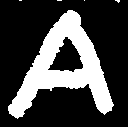

In [ ]:
display_spin_field(denoising_step(noisy_img=img_noisy,
                                  field=random_spin_field(*img.shape),
                                  log_obs_likelihood=gaussian_log_likelihood,
                                  J=0.4,
                                  num_iter=1))                        # you may tune hyper-parameters in log_obs_likelihood function, J, and num_iter etc.

Beside denoing image with injected Gaussian noise, you may explore other settings: such as upsampling an image ...

Can you think up a setting where this model (completely) fails? Why?

### Image upsampling

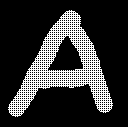

In [ ]:
img_subsample = img_clean.astype('float')
img_subsample[::2, ::2] = -1 # or 1

display_spin_field(img_subsample)

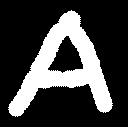

In [ ]:
display_spin_field(denoising_step(noisy_img=img_subsample,
                                  field=random_spin_field(*img.shape),
                                  log_obs_likelihood=gaussian_log_likelihood,
                                  J=0.4,
                                  num_iter=5))

### One example setting where this model completely fails: image completion

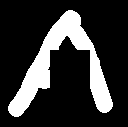

In [ ]:
img_shelter = img_clean.astype('float')
img_shelter[50:90, 50:90] = -1

display_spin_field(img_shelter)

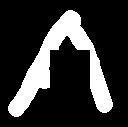

In [ ]:
display_spin_field(denoising_step(noisy_img=img_shelter,
                                  field=random_spin_field(*img.shape),
                                  log_obs_likelihood=gaussian_log_likelihood,
                                  J=0.4,
                                  num_iter=5))

To elucidate the reasons behind our model's complete failure in image completion when confronted with block occlusion, it is essential to revisit the fundamental assumption of the Ising model. In the Ising model, each variable, taking on a value of either -1 or +1, is conditionally independent of all other variables, provided the values of its neighboring variables. Our model's effectiveness in image denoising is similarly rooted in its ability to exploit neighboring information, as aligned with the principles of the Ising model. However, in the context of image completion where an entire block of the image is missing, the model is unable to utilize nearby pixel information, ultimately leading to its failure in performing this task.


 Extra Exercise: For Ising model example, one may also consider putting an external magnetic field over the lattice, which leads to a new energy formulation. How to modify the above code to accomodate this change?

hint: You may change the _energy part.